In [ ]:
#| default_exp models.itransformer

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

# iTransformer

The iTransformer model simply takes the Transformer architecture but it applies the attention and feed-forward network on the inverted dimensions. This means that time points of each individual series are embedded into tokens. That way, the attention mechanisms learn multivariate correlation and the feed-forward network learns non-linear relationships.

**References**
- [Yong Liu, Tengge Hu, Haoran Zhang, Haixu Wu, Shiyu Wang, Lintao Ma, Mingsheng Long. "iTransformer: Inverted Transformers Are Effective for Time Series Forecasting"](https://arxiv.org/abs/2310.06625)

![Figure 1. Architecture of iTransformer.](imgs_models/itransformer.png)

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from math import sqrt

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_multivariate import BaseMultivariate

from neuralforecast.common._modules import TransEncoder, TransEncoderLayer, AttentionLayer

# 1. Auxiliary functions

## 1.1 Attention

In [ ]:
#| exporti

class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)      

## 1.2 Inverted embedding

In [ ]:
#| exporti

class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, hidden_size, dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, hidden_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)
        # x: [Batch Variate Time]
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            # the potential to take covariates (e.g. timestamps) as tokens
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1)) 
        # x: [Batch Variate hidden_size]
        return self.dropout(x)

# 2. Model

In [ ]:
#| export

class iTransformer(BaseMultivariate):

    """ iTransformer

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `n_series`: int, number of time-series.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hidden_size`: int, dimension of the model.<br>
    `n_heads`: int, number of heads.<br>
    `e_layers`: int, number of encoder layers.<br>
    `d_layers`: int, number of decoder layers.<br>
    `d_ff`: int, dimension of fully-connected layer.<br>
    `factor`: int, attention factor.<br>
    `dropout`: float, dropout rate.<br>
    `use_norm`: bool, whether to normalize or not.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>
    
    **References**<br>
    - [Yong Liu, Tengge Hu, Haoran Zhang, Haixu Wu, Shiyu Wang, Lintao Ma, Mingsheng Long. "iTransformer: Inverted Transformers Are Effective for Time Series Forecasting"](https://arxiv.org/abs/2310.06625)
    """

    # Class attributes
    SAMPLING_TYPE = 'multivariate'
    EXOGENOUS_FUTR = False
    EXOGENOUS_HIST = False
    EXOGENOUS_STAT = False

    def __init__(self,
                 h,
                 input_size,
                 n_series,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 hidden_size: int = 512,
                 n_heads: int = 8,
                 e_layers: int = 2,
                 d_layers: int = 1,
                 d_ff: int = 2048,
                 factor: int = 1,
                 dropout: float = 0.1,
                 use_norm: bool = True,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,            
                 **trainer_kwargs):
        
        super(iTransformer, self).__init__(h=h,
                                           input_size=input_size,
                                           n_series=n_series,
                                           stat_exog_list = None,
                                           futr_exog_list = None,
                                           hist_exog_list = None,
                                           loss=loss,
                                           valid_loss=valid_loss,
                                           max_steps=max_steps,
                                           learning_rate=learning_rate,
                                           num_lr_decays=num_lr_decays,
                                           early_stop_patience_steps=early_stop_patience_steps,
                                           val_check_steps=val_check_steps,
                                           batch_size=batch_size,
                                           step_size=step_size,
                                           scaler_type=scaler_type,
                                           random_seed=random_seed,
                                           num_workers_loader=num_workers_loader,
                                           drop_last_loader=drop_last_loader,
                                           optimizer=optimizer,
                                           optimizer_kwargs=optimizer_kwargs,
                                           lr_scheduler=lr_scheduler,
                                           lr_scheduler_kwargs=lr_scheduler_kwargs,
                                           **trainer_kwargs)
               
        self.enc_in = n_series
        self.dec_in = n_series
        self.c_out = n_series
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.e_layers = e_layers
        self.d_layers = d_layers
        self.d_ff = d_ff
        self.factor = factor
        self.dropout = dropout
        self.use_norm = use_norm

        # Architecture
        self.enc_embedding = DataEmbedding_inverted(input_size, self.hidden_size, self.dropout)

        self.encoder = TransEncoder(
            [
                TransEncoderLayer(
                    AttentionLayer(
                        FullAttention(False, self.factor, attention_dropout=self.dropout), self.hidden_size, self.n_heads),
                    self.hidden_size,
                    self.d_ff,
                    dropout=self.dropout,
                    activation=F.gelu
                ) for l in range(self.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(self.hidden_size)
        )

        self.projector = nn.Linear(self.hidden_size, h, bias=True)
    
    def forecast(self, x_enc):
        if self.use_norm:
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        _, _, N = x_enc.shape # B L N
        # B: batch_size;       E: hidden_size; 
        # L: input_size;       S: horizon(h);
        # N: number of variate (tokens), can also includes covariates

        # Embedding
        # B L N -> B N E                (B L N -> B L E in the vanilla Transformer)
        enc_out = self.enc_embedding(x_enc, None) # covariates (e.g timestamp) can be also embedded as tokens
        
        # B N E -> B N E                (B L E -> B L E in the vanilla Transformer)
        # the dimensions of embedded time series has been inverted, and then processed by native attn, layernorm and ffn modules
        enc_out, attns = self.encoder(enc_out, attn_mask=None)

        # B N E -> B N S -> B S N 
        dec_out = self.projector(enc_out).permute(0, 2, 1)[:, :, :N] # filter the covariates

        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.h, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.h, 1))

        return dec_out
    
    def forward(self, windows_batch):
        insample_y = windows_batch['insample_y']

        y_pred = self.forecast(insample_y)
        y_pred = y_pred[:, -self.h:, :]
        y_pred = self.loss.domain_map(y_pred)

        # domain_map might have squeezed the last dimension in case n_series == 1
        if y_pred.ndim == 2:
            return y_pred.unsqueeze(-1)
        else:
            return y_pred


In [ ]:
show_doc(iTransformer)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/itransformer.py#L93){target="_blank" style="float:right; font-size:smaller"}

### iTransformer

>      iTransformer (h, input_size, n_series, futr_exog_list=None,
>                    hist_exog_list=None, stat_exog_list=None,
>                    hidden_size:int=512, n_heads:int=8, e_layers:int=2,
>                    d_layers:int=1, d_ff:int=2048, factor:int=1,
>                    dropout:float=0.1, use_norm:bool=True, loss=MAE(),
>                    valid_loss=None, max_steps:int=1000,
>                    learning_rate:float=0.001, num_lr_decays:int=-1,
>                    early_stop_patience_steps:int=-1, val_check_steps:int=100,
>                    batch_size:int=32, step_size:int=1,
>                    scaler_type:str='identity', random_seed:int=1,
>                    num_workers_loader:int=0, drop_last_loader:bool=False,
>                    optimizer=None, optimizer_kwargs=None, lr_scheduler=None,
>                    lr_scheduler_kwargs=None, **trainer_kwargs)

iTransformer

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`n_series`: int, number of time-series.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hidden_size`: int, dimension of the model.<br>
`n_heads`: int, number of heads.<br>
`e_layers`: int, number of encoder layers.<br>
`d_layers`: int, number of decoder layers.<br>
`d_ff`: int, dimension of fully-connected layer.<br>
`factor`: int, attention factor.<br>
`dropout`: float, dropout rate.<br>
`use_norm`: bool, whether to normalize or not.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

**References**<br>
- [Yong Liu, Tengge Hu, Haoran Zhang, Haixu Wu, Shiyu Wang, Lintao Ma, Mingsheng Long. "iTransformer: Inverted Transformers Are Effective for Time Series Forecasting"](https://arxiv.org/abs/2310.06625)

In [ ]:
show_doc(iTransformer.fit, name='iTransformer.fit')

---

### iTransformer.fit

>      iTransformer.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                        distributed_config=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(iTransformer.predict, name='iTransformer.predict')

---

### iTransformer.predict

>      iTransformer.predict (dataset, test_size=None, step_size=1,
>                            random_seed=None, **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

# 3. Usage example

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MSE

In [ ]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = iTransformer(h=12,
                     input_size=24,
                     n_series=2,
                     hidden_size=128,
                     n_heads=2,
                     e_layers=2,
                     d_layers=1,
                     d_ff=4,
                     factor=1,
                     dropout=0.1,
                     use_norm=True,
                     loss=MSE(),
                     valid_loss=MAE(),
                     early_stop_patience_steps=3,
                     batch_size=32)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params
---------------------------------------------------------
0 | loss          | MSE                    | 0     
1 | valid_loss    | MAE                    | 0     
2 | padder        | ConstantPad1d          | 0     
3 | scaler        | TemporalNorm           | 0     
4 | enc_embedding | DataEmbedding_inverted | 3.2 K 
5 | encoder       | TransEncoder           | 135 K 
6 | projector     | Linear                 | 1.5 K 
---------------------------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.562     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/core.py:201: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


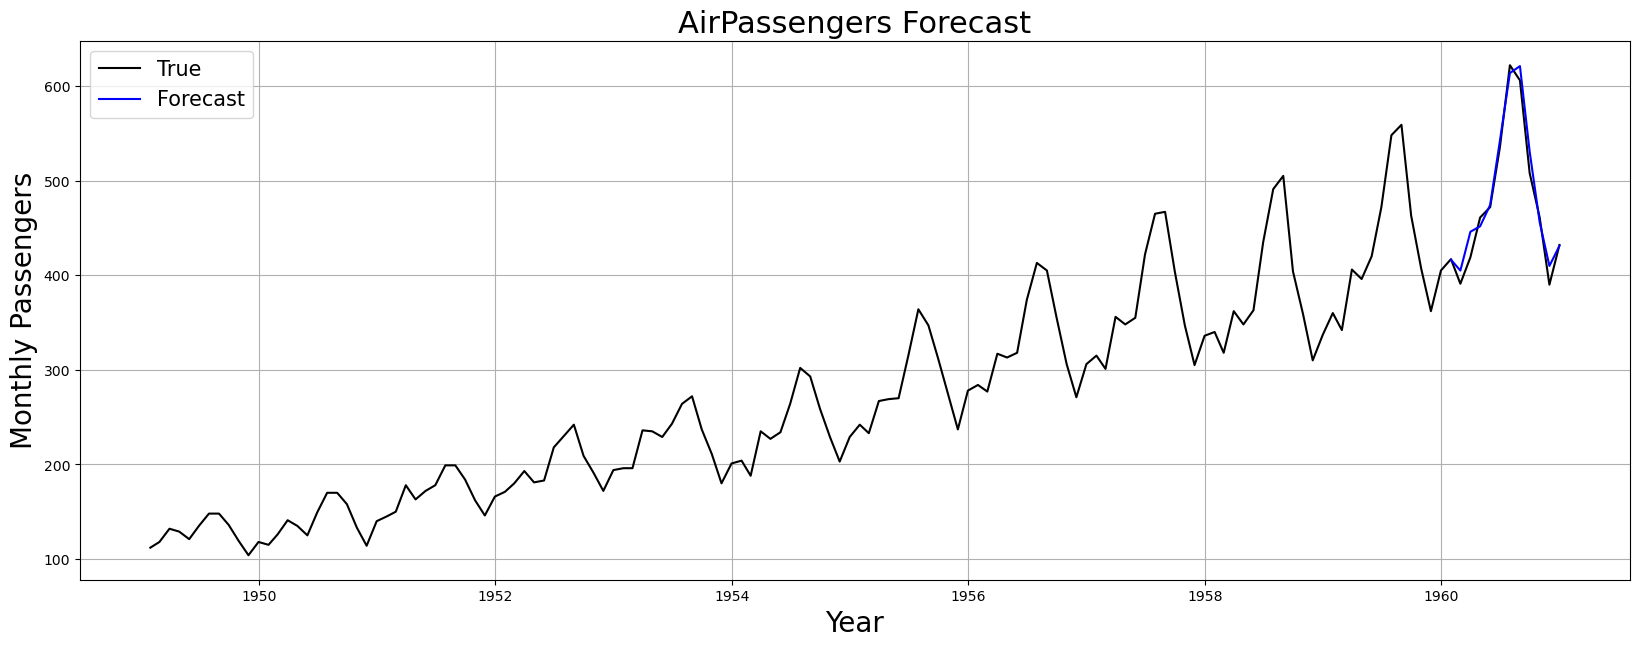

In [ ]:
#| eval: false
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['iTransformer'], c='blue', label='Forecast')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MSE

In [ ]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = iTransformer(h=12,
                     input_size=24,
                     n_series=1,
                     hidden_size=128,
                     n_heads=2,
                     e_layers=2,
                     d_layers=1,
                     d_ff=4,
                     factor=1,
                     dropout=0.1,
                     use_norm=True,
                     loss=MSE(),
                     valid_loss=MAE(),
                     early_stop_patience_steps=3,
                     batch_size=32)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params
---------------------------------------------------------
0 | loss          | MSE                    | 0     
1 | valid_loss    | MAE                    | 0     
2 | padder        | ConstantPad1d          | 0     
3 | scaler        | TemporalNorm           | 0     
4 | enc_embedding | DataEmbedding_inverted | 3.2 K 
5 | encoder       | TransEncoder           | 135 K 
6 | projector     | Linear                 | 1.5 K 
---------------------------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.562     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/core.py:201: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
